<a href="https://colab.research.google.com/github/sheddie00/learn-git/blob/main/Unsupervised_Learning_checkP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import of neccessary libraries

In [ ]:
!pip install scikit-learn

In [ ]:
# Import neccesary libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy .cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering


In [ ]:
# Load data
credit_card_csv= '/content/drive/MyDrive/Credit_card_dataset.csv'
df= pd.read_csv(credit_card_csv)
print(df)


     CUST_ID  BALANCE_FREQUENCY  PURCHASES     PAYMENTS  CREDIT_LIMIT  \
0     C10001           0.818182      95.40   201.802084        1000.0   
1     C10002           0.909091       0.00  4103.032597        7000.0   
2     C10003           1.000000     773.17   622.066742        7500.0   
3     C10004           0.636364    1499.00     0.000000        7500.0   
4     C10005           1.000000      16.00   678.334763        1200.0   
...      ...                ...        ...          ...           ...   
8945  C19186           1.000000     291.12   325.594462        1000.0   
8946  C19187           1.000000     300.00   275.861322        1000.0   
8947  C19188           0.833333     144.40    81.270775        1000.0   
8948  C19189           0.833333       0.00    52.549959         500.0   
8949  C19190           0.666667    1093.25    63.165404        1200.0   

      CASH_ADVANCE  
0         0.000000  
1      6442.945483  
2         0.000000  
3       205.788017  
4         0.000000

Basic data cleaning/Preprocessing

In [ ]:
# Understanding the credit card dataset
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


,0
CUST_ID,0
BALANCE_FREQUENCY,0
PURCHASES,0
PAYMENTS,0
CREDIT_LIMIT,1
CASH_ADVANCE,0


In [ ]:
df.describe()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000
mean,0.877271,1003.204834,1733.143852,4494.449450,978.871112
std,0.236904,2136.634782,2895.063757,3638.815725,2097.163877
min,0.000000,0.000000,0.000000,50.000000,0.000000
25%,0.888889,39.635000,383.276166,1600.000000,0.000000
50%,1.000000,361.280000,856.901546,3000.000000,0.000000
75%,1.000000,1110.130000,1901.134317,6500.000000,1113.821139
max,1.000000,49039.570000,50721.483360,30000.000000,47137.211760


In [ ]:
# Drop rows with missing CREDIT_LIMIT
df_cleaned = df.dropna(subset=["CREDIT_LIMIT"]) # Removes the row with 1 missing value

# Drop CUST_ID as it's not useful for modeling
df_cleaned = df_cleaned.drop(columns=["CUST_ID"])


In [ ]:
# check the cleaned data
print(df_cleaned.info())
print(df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 8949 entries, 0 to 8949
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BALANCE_FREQUENCY  8949 non-null   float64
 1   PURCHASES          8949 non-null   float64
 2   PAYMENTS           8949 non-null   float64
 3   CREDIT_LIMIT       8949 non-null   float64
 4   CASH_ADVANCE       8949 non-null   float64
dtypes: float64(5)
memory usage: 419.5 KB
None
   BALANCE_FREQUENCY  PURCHASES     PAYMENTS  CREDIT_LIMIT  CASH_ADVANCE
0           0.818182      95.40   201.802084        1000.0      0.000000
1           0.909091       0.00  4103.032597        7000.0   6442.945483
2           1.000000     773.17   622.066742        7500.0      0.000000
3           0.636364    1499.00     0.000000        7500.0    205.788017
4           1.000000      16.00   678.334763        1200.0      0.000000


In [ ]:
# In this case, no encoding is needed — and here’s why:
# 1. You now have these 5 features, all numerical

# There are no categorical variables, so:
# 1.Label encoding (for converting category labels to numbers) → not needed
# 2. One-hot encoding (for binary flags or categories) → not needed



Before performing hierarchical clustering, scaled the data.

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the cleaned data
scaled_data = scaler.fit_transform(df_cleaned)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_cleaned.columns)

# Display the first few rows
print(df_scaled.head())

   BALANCE_FREQUENCY  PURCHASES  PAYMENTS  CREDIT_LIMIT  CASH_ADVANCE
0          -0.249881  -0.424934 -0.529026     -0.960380     -0.466805
1           0.134049  -0.469584  0.818546      0.688601      2.605438
2           0.517980  -0.107716 -0.383857      0.826016     -0.466805
3          -1.017743   0.231995 -0.598733      0.826016     -0.368678
4           0.517980  -0.462095 -0.364421     -0.905414     -0.466805


Hierarchical clustering

In [ ]:
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
linkage_matrix = sch.linkage(scaled_data, method='ward')

/tmp/ipython-input-1391800452.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_2d['KMeans_Cluster'] = labels


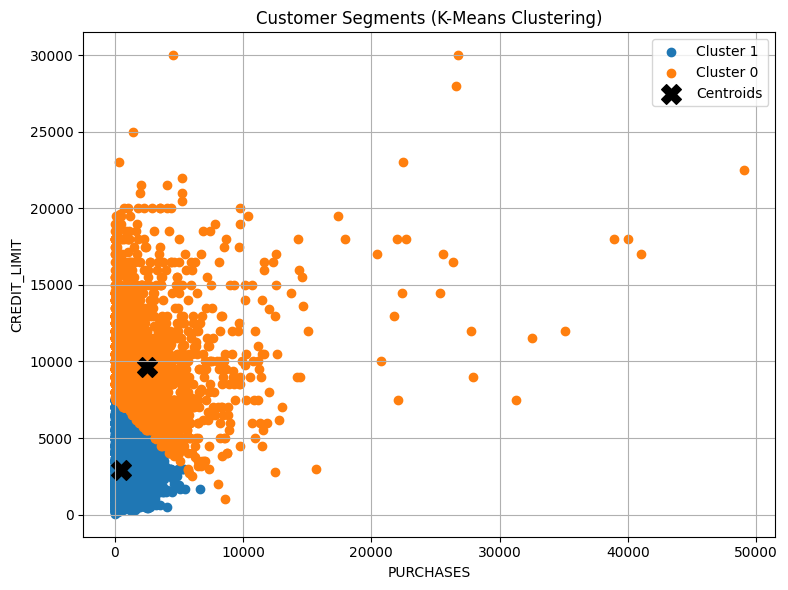

In [ ]:
# Use only two features for clustering
features_2d = df_cleaned[['PURCHASES', 'CREDIT_LIMIT']]

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_2d)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the DataFrame
features_2d['KMeans_Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(8, 6))
for label in features_2d['KMeans_Cluster'].unique():
    cluster_data = features_2d[features_2d['KMeans_Cluster'] == label]
    plt.scatter(cluster_data['PURCHASES'], cluster_data['CREDIT_LIMIT'], label=f'Cluster {label}')

# Plot the centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.title('Customer Segments (K-Means Clustering)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Got the best k value and plotted  the clusters again.

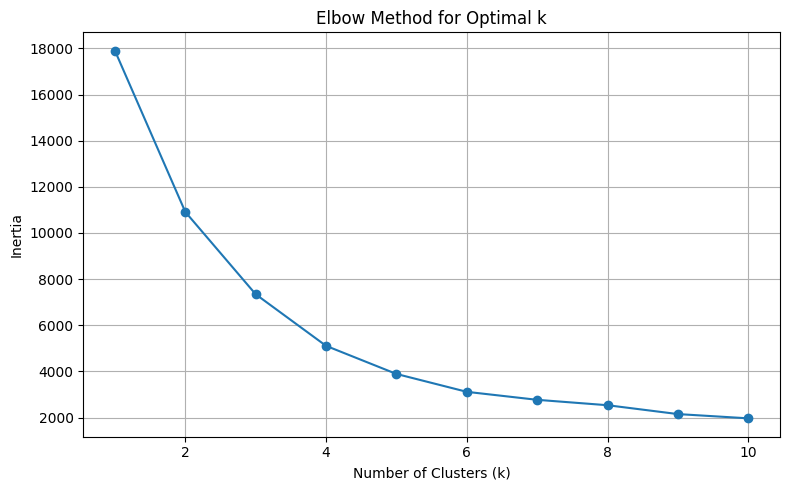

In [ ]:
# Elbow Method: find optimal k
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Plot inertia vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()
# Looking at the elbow point my best k is 4

Elbow Method suggests the best number of clusters is 3.

Cluster 0: Low purchases, low credit limit — likely low-value or new customers.

Cluster 1: High purchases, high credit limit — high-value, premium customers.

Cluster 2: Moderate purchases and credit — average or stable users.

Each group can be targeted with different marketing strategies based on spending and credit profiles.